In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl

In [0]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch import LongTensor, FloatTensor
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.nn.functional as func
import nltk
from sklearn.metrics import precision_recall_fscore_support, f1_score, recall_score

In [0]:
# Get Data
sim_train = np.load("sim_train.npy")
desc_train = np.load("description_train.npy")
y_train = np.load("targets_train.npy")


sim_val = np.load("sim_val.npy")
desc_val = np.load("description_val.npy")
y_val = np.load("targets_val.npy")

sim_test = np.load("sim_test.npy")
desc_test = np.load("description_test.npy")
y_test = np.load("targets_test.npy")

import json
with open("word2idx_v1", "r") as fp:
  word2idx=json.load(fp) 

#random_seed = 11
#np.random.seed(random_seed)
#torch.manual_seed(random_seed)
#torch.cuda.manual_seed(random_seed)  

# Load Embeddings
  
weights_matrix = np.load("glove_weights_v1.npy")
emb_layer = nn.Embedding(num_embeddings=len(word2idx), embedding_dim=300,
                         padding_idx=0).cuda()
emb_layer.weight.data.copy_(torch.from_numpy(weights_matrix))
emb_layer.weight.requires_grad = False

In [0]:
batch_size = 100

class Transform(Dataset):
    def __init__(self, sim, description, label, word2idx):
        self.sim = sim
        self.desc = description
        self.label = label
        self.word2idx = word2idx
        self.max_len_desc1 = 50#1997 - 75% 
        self.max_len_desc2 = 50#52

    def __len__(self):
        return len(self.label)#+len(self.desc)+len(self.sim)

    def __getitem__(self, index):
        sim = self.sim[index]
        desc1 = self.desc[index][0]
        desc2 = self.desc[index][1]
        label = self.label[index]

        desc1_idx1 = [self.word2idx.get(word, 1) for word in desc1]
        desc2_idx1 = [self.word2idx.get(word, 1) for word in desc2]

        if len(desc1_idx1) > self.max_len_desc1:
            desc1_idx1 = desc1_idx1[:self.max_len_desc1]
        if len(desc2_idx1) > self.max_len_desc2:
            desc2_idx1 = desc2_idx1[:self.max_len_desc2]

        # Zero pad
        desc1_idx = LongTensor(1, self.max_len_desc1).zero_()  # N X max_len
        desc2_idx = LongTensor(1, self.max_len_desc2).zero_()
        # print(desc1_idx1.shape, len(desc1_idx))
        # print(desc2_idx1.shape, len(desc2_idx))
        if len(desc1_idx1)!=0:
            desc1_idx[0, 0:len(desc1_idx1)].copy_(LongTensor(desc1_idx1))
        if len(desc2_idx1) != 0:
            desc2_idx[0, 0:len(desc2_idx1)].copy_(LongTensor(desc2_idx1))

        return desc1_idx, desc2_idx, sim, label


train_dataset = Transform(sim_train, pd.DataFrame(desc_train).to_dict('records'), y_train,
                          word2idx)
train_sampler = torch.utils.data.sampler.RandomSampler(train_dataset)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=5,
    pin_memory=True)

dev_dataset = Transform(sim_val, pd.DataFrame(desc_val).to_dict('records'), y_val,
                        word2idx)  # feature2idx,
dev_sampler = torch.utils.data.sampler.SequentialSampler(dev_dataset)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, sampler=dev_sampler, num_workers=5,
    pin_memory=True)

In [0]:
'''
Model Definition
'''

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()

        self.rnn1 = nn.LSTM(input_size=300, hidden_size=50, bidirectional=True,
                            num_layers=1) # for entity1
        self.rnn2 = nn.LSTM(input_size=300, hidden_size=50, bidirectional=True,
                            num_layers=1)  # for entity1
        # self.rnn2 = nn.LSTM(input_size=300, hidden_size=50) # for entity2
        # self.rnnbi2 = nn.LSTM(input_size=300, hidden_size=50, bidirectional=True)

        self.fcn1 = nn.Sequential(
            nn.Linear(207, 50),  # 53
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )  # nn.Dropout(0.2) nn.Linear(100, 1),
        # self.merge_fcn1.weight.data.normal_()

        self.final_fcn = nn.Sequential(
            nn.Linear(50, 2))  # nn.Dropout(0.2) nn.Linear(100, 1), nn.ReLU(inplace=True),
        # self.final_fcn.weight.data.normal_() nn.ReLU(inplace=True),



    def forward(self, desc1_embed, desc2_embed, sim):

        batch_size = desc1_embed.size()[0]

        desc1_encoded = self.rnn1(desc1_embed.transpose(1, 0))[1][0]
        forward_state1, backward_state1 = desc1_encoded[0, :, :].squeeze(), \
                                          desc1_encoded[1, :, :].squeeze()
        merged_state1 = torch.cat((forward_state1, backward_state1), dim=1)

        desc2_encoded = self.rnn2(desc2_embed.transpose(1, 0))[1][0]
        forward_state2, backward_state2 = desc2_encoded[0, :, :].squeeze(), \
                                          desc2_encoded[1, :, :].squeeze()
        merged_state2 = torch.cat((forward_state2, backward_state2), dim=1)

#         print("A1: ", merged_state1.size())
#         print("A2: ", merged_state2.size())
#         print("sim: ", sim.size())
#         print(type(sim))
#         print(type(desc1_encoded - desc2_encoded))
        sim_added = torch.cat([merged_state1 - merged_state2,
                               merged_state1 * merged_state2,
                               sim.float()], 1)
        #print("final: ", sim_added.size())

        output = self.fcn1(sim_added)

        final = self.final_fcn(output)
        #        print(final.size())
        return final


'''
Initialize model
'''
# Initialize the model
matcher = Model().cuda()
optimizer = optim.Adam(matcher.parameters())
# optimizer = optim.Adadelta(reader.parameters(), lr=0.001)
# optimizer = optim.SGD(reader.parameters(), lr = 0.05)
torch.cuda.set_device(-1)
# model_name = 'with_topics_best'
class_sample_count = [len(np.where(y_train==0)[0]),len(np.where(y_train==1)[0])]
weights = 1 / torch.Tensor(class_sample_count)
# weights = torch.FloatTensor([0.1,1])
loss_func = nn.CrossEntropyLoss(weight=weights.cuda())
# loss_func = nn.CrossEntropyLoss()

for m in matcher.modules():
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.02)
        # torch.nn.init.xavier_normal_(m.weight)



In [0]:
def validate(data_loader, network):
    correct = 0
    examples = 0
    truth = []
    prediction = []

    for ex in data_loader:
        batch_size = ex[0].size(0)

        # Predicting....
        network.eval()

        desc1_idx = Variable(ex[0]).cuda()
        desc2_idx = Variable(ex[1]).cuda()
        sim = Variable(ex[2]).cuda()
        actual = Variable(ex[3]).cuda()

        desc1_embed = emb_layer(desc1_idx.squeeze())
        desc2_embed = emb_layer(desc2_idx.squeeze())
        # ques622_embed = emb_layer(ques622.repeat(ans622.size()[0], 1))
        #        print(ques622_embed.size())

        output = network(desc1_embed, desc2_embed, sim)

        _, pred = torch.max(output, 1)
        truth.append(list(actual.data))
        prediction.append(list(pred.data))
        correct += (pred.data == actual.data).sum()

        examples += batch_size

    truth_flat = [item for sublist in truth for item in sublist]
    pred_flat = [item for sublist in prediction for item in sublist]

    f1 = f1_score(truth_flat, pred_flat)
    recall = recall_score(truth_flat, pred_flat)

    return correct / examples, f1, recall

In [0]:
'''
Training
'''

num_epochs = 10

loss_list = []
train_list = []
test_list = []

for epoch in range(0, num_epochs):
# for epoch in range(10, 30):
    train_loss = 0
    for idx, sample in enumerate(train_loader):

        matcher.train()
        desc1_idx = Variable(sample[0]).cuda()
        desc2_idx = Variable(sample[1]).cuda()
        sim = Variable(sample[2]).cuda()
        actual = Variable(sample[3]).cuda()

        desc1_embed = emb_layer(desc1_idx.squeeze())
        desc2_embed = emb_layer(desc2_idx.squeeze())

        pred = matcher(desc1_embed, desc2_embed, sim)


        loss = loss_func(pred, actual)
        optimizer.zero_grad()  # set gradients to zero for each iteration
        loss.backward()  # backpropagate
        optimizer.step()  # update parameters

        # print(loss.data)
        loss_list.append(loss.data[0])

        train_loss += loss.data[0]
        # print(idx)
        if (idx % 250 == 0):
            print("Epoch", epoch + 1, "Batch-step", idx, "\t/",
                  len(train_loader), "\tloss", loss.data[0])
            train_loss = 0
    torch.save({
            'epoch': epoch,
            'model_state_dict': matcher.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            },str(epoch)+"model")
    val_acc, val_f1, val_recall = validate(dev_loader, matcher)
    train_acc, train_f1, train_recall = validate(train_loader, matcher)
    print(val_f1)
    print(train_f1)
    test_list.append(val_f1)
    train_list.append(train_f1)

Epoch 1 Batch-step 0 	/ 2466 	loss 0.8483333587646484
Epoch 1 Batch-step 250 	/ 2466 	loss 0.1918594390153885
Epoch 1 Batch-step 500 	/ 2466 	loss 0.06793055683374405
Epoch 1 Batch-step 750 	/ 2466 	loss 0.06556885689496994
Epoch 1 Batch-step 1000 	/ 2466 	loss 0.13711048662662506
Epoch 1 Batch-step 1250 	/ 2466 	loss 0.10796051472425461
Epoch 1 Batch-step 1500 	/ 2466 	loss 0.09873601049184799
Epoch 1 Batch-step 1750 	/ 2466 	loss 0.0746016725897789
Epoch 1 Batch-step 2000 	/ 2466 	loss 0.039669815450906754
Epoch 1 Batch-step 2250 	/ 2466 	loss 0.09036006033420563
0.2360655737704918
0.25751734772552043
Epoch 2 Batch-step 0 	/ 2466 	loss 0.09788727015256882
Epoch 2 Batch-step 250 	/ 2466 	loss 0.045995499938726425
Epoch 2 Batch-step 500 	/ 2466 	loss 0.059624578803777695
Epoch 2 Batch-step 750 	/ 2466 	loss 0.11955681443214417
Epoch 2 Batch-step 1000 	/ 2466 	loss 0.12089870870113373
Epoch 2 Batch-step 1250 	/ 2466 	loss 0.07029160857200623
Epoch 2 Batch-step 1500 	/ 2466 	loss 0.16978

In [0]:
'''
Training
'''

num_epochs = 10

for epoch in range(num_epochs,20):
# for epoch in range(10, 30):
    train_loss = 0
    for idx, sample in enumerate(train_loader):

        matcher.train()
        desc1_idx = Variable(sample[0]).cuda()
        desc2_idx = Variable(sample[1]).cuda()
        sim = Variable(sample[2]).cuda()
        actual = Variable(sample[3]).cuda()

        desc1_embed = emb_layer(desc1_idx.squeeze())
        desc2_embed = emb_layer(desc2_idx.squeeze())

        pred = matcher(desc1_embed, desc2_embed, sim)


        loss = loss_func(pred, actual)
        optimizer.zero_grad()  # set gradients to zero for each iteration
        loss.backward()  # backpropagate
        optimizer.step()  # update parameters

        # print(loss.data)
        loss_list.append(loss.data[0])

        train_loss += loss.data[0]
        # print(idx)
        if (idx % 250 == 0):
            print("Epoch", epoch + 1, "Batch-step", idx, "\t/",
                  len(train_loader), "\tloss", loss.data[0])
            train_loss = 0
    torch.save({
            'epoch': epoch,
            'model_state_dict': matcher.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            },str(epoch)+"model")
    val_acc, val_f1, val_recall = validate(dev_loader, matcher)
    train_acc, train_f1, train_recall = validate(train_loader, matcher)
    print(val_f1)
    print(train_f1)
    test_list.append(val_f1)
    train_list.append(train_f1)

Epoch 11 Batch-step 0 	/ 2466 	loss 0.005334311164915562
Epoch 11 Batch-step 250 	/ 2466 	loss 0.00019492865249048918
Epoch 11 Batch-step 500 	/ 2466 	loss 0.028347061946988106
Epoch 11 Batch-step 750 	/ 2466 	loss 0.03912602737545967
Epoch 11 Batch-step 1000 	/ 2466 	loss 0.014390712603926659
Epoch 11 Batch-step 1250 	/ 2466 	loss 0.01768006756901741
Epoch 11 Batch-step 1500 	/ 2466 	loss 0.008400767110288143
Epoch 11 Batch-step 1750 	/ 2466 	loss 0.0034110245760530233
Epoch 11 Batch-step 2000 	/ 2466 	loss 0.0010971581796184182
Epoch 11 Batch-step 2250 	/ 2466 	loss 0.0027805184945464134
0.36297640653357527
0.5830564784053156
Epoch 12 Batch-step 0 	/ 2466 	loss 0.007120696362107992
Epoch 12 Batch-step 250 	/ 2466 	loss 0.014539600349962711
Epoch 12 Batch-step 500 	/ 2466 	loss 0.004792322404682636
Epoch 12 Batch-step 750 	/ 2466 	loss 0.010296648368239403
Epoch 12 Batch-step 1000 	/ 2466 	loss 0.0029496061615645885
Epoch 12 Batch-step 1250 	/ 2466 	loss 0.007738740183413029
Epoch 12 

In [0]:
'''
Training
'''

num_epochs = 10

for epoch in range(20,30):
# for epoch in range(10, 30):
    train_loss = 0
    for idx, sample in enumerate(train_loader):

        matcher.train()
        desc1_idx = Variable(sample[0]).cuda()
        desc2_idx = Variable(sample[1]).cuda()
        sim = Variable(sample[2]).cuda()
        actual = Variable(sample[3]).cuda()

        desc1_embed = emb_layer(desc1_idx.squeeze())
        desc2_embed = emb_layer(desc2_idx.squeeze())

        pred = matcher(desc1_embed, desc2_embed, sim)


        loss = loss_func(pred, actual)
        optimizer.zero_grad()  # set gradients to zero for each iteration
        loss.backward()  # backpropagate
        optimizer.step()  # update parameters

        # print(loss.data)
        loss_list.append(loss.data[0])

        train_loss += loss.data[0]
        # print(idx)
        if (idx % 250 == 0):
            print("Epoch", epoch + 1, "Batch-step", idx, "\t/",
                  len(train_loader), "\tloss", loss.data[0])
            train_loss = 0
    torch.save({
            'epoch': epoch,
            'model_state_dict': matcher.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            },str(epoch)+"model")
    val_acc, val_f1, val_recall = validate(dev_loader, matcher)
    train_acc, train_f1, train_recall = validate(train_loader, matcher)
    print(val_f1)
    print(train_f1)
    test_list.append(val_f1)
    train_list.append(train_f1)

Epoch 21 Batch-step 0 	/ 2466 	loss 0.04753519222140312
Epoch 21 Batch-step 250 	/ 2466 	loss 0.0020055617205798626
Epoch 21 Batch-step 500 	/ 2466 	loss 0.00052739615784958
Epoch 21 Batch-step 750 	/ 2466 	loss 0.0010239065159112215
Epoch 21 Batch-step 1000 	/ 2466 	loss 0.004434239584952593
Epoch 21 Batch-step 1250 	/ 2466 	loss 0.0005894256755709648
Epoch 21 Batch-step 1500 	/ 2466 	loss 4.139216252951883e-05
Epoch 21 Batch-step 1750 	/ 2466 	loss 0.0007004618528299034
Epoch 21 Batch-step 2000 	/ 2466 	loss 0.0047880071215331554
Epoch 21 Batch-step 2250 	/ 2466 	loss 0.0002644086198415607
0.3444816053511706
0.5508607198748044
Epoch 22 Batch-step 0 	/ 2466 	loss 0.010633501224219799
Epoch 22 Batch-step 250 	/ 2466 	loss 0.06138013303279877
Epoch 22 Batch-step 500 	/ 2466 	loss 0.007609546650201082
Epoch 22 Batch-step 750 	/ 2466 	loss 0.006084210705012083
Epoch 22 Batch-step 1000 	/ 2466 	loss 0.0090559683740139
Epoch 22 Batch-step 1250 	/ 2466 	loss 0.0001465344539610669
Epoch 22 Ba

In [0]:
'''
Training 4
'''

num_epochs = 10

for epoch in range(30,40):
# for epoch in range(10, 30):
    train_loss = 0
    for idx, sample in enumerate(train_loader):

        matcher.train()
        desc1_idx = Variable(sample[0]).cuda()
        desc2_idx = Variable(sample[1]).cuda()
        sim = Variable(sample[2]).cuda()
        actual = Variable(sample[3]).cuda()

        desc1_embed = emb_layer(desc1_idx.squeeze())
        desc2_embed = emb_layer(desc2_idx.squeeze())

        pred = matcher(desc1_embed, desc2_embed, sim)


        loss = loss_func(pred, actual)
        optimizer.zero_grad()  # set gradients to zero for each iteration
        loss.backward()  # backpropagate
        optimizer.step()  # update parameters

        # print(loss.data)
        loss_list.append(loss.data[0])

        train_loss += loss.data[0]
        # print(idx)
        if (idx % 250 == 0):
            print("Epoch", epoch + 1, "Batch-step", idx, "\t/",
                  len(train_loader), "\tloss", loss.data[0])
            train_loss = 0
    torch.save({
            'epoch': epoch,
            'model_state_dict': matcher.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            },str(epoch)+"model")
    val_acc, val_f1, val_recall = validate(dev_loader, matcher)
    train_acc, train_f1, train_recall = validate(train_loader, matcher)
    print(val_f1)
    print(train_f1)
    test_list.append(val_f1)
    train_list.append(train_f1)

Epoch 31 Batch-step 0 	/ 2466 	loss 0.0039533390663564205
Epoch 31 Batch-step 250 	/ 2466 	loss 0.0005124867893755436
Epoch 31 Batch-step 500 	/ 2466 	loss 0.00438856752589345
Epoch 31 Batch-step 750 	/ 2466 	loss 0.00312925036996603
Epoch 31 Batch-step 1000 	/ 2466 	loss 1.7793179722502828e-05
Epoch 31 Batch-step 1250 	/ 2466 	loss 0.2961566746234894
Epoch 31 Batch-step 1500 	/ 2466 	loss 9.353206223750021e-06
Epoch 31 Batch-step 1750 	/ 2466 	loss 0.001852409914135933
Epoch 31 Batch-step 2000 	/ 2466 	loss 0.007244201842695475
Epoch 31 Batch-step 2250 	/ 2466 	loss 7.200241611826641e-07
0.39651416122004357
0.7200000000000001
Epoch 32 Batch-step 0 	/ 2466 	loss 0.01726682297885418
Epoch 32 Batch-step 250 	/ 2466 	loss 0.0027536095585674047
Epoch 32 Batch-step 500 	/ 2466 	loss 0.006285465322434902
Epoch 32 Batch-step 750 	/ 2466 	loss 1.6345977201126516e-05
Epoch 32 Batch-step 1000 	/ 2466 	loss 0.00227029318921268
Epoch 32 Batch-step 1250 	/ 2466 	loss 8.255243301391602e-05
Epoch 32 

In [0]:
'''
Training 4
'''

num_epochs = 10

for epoch in range(40,50):
# for epoch in range(10, 30):
    train_loss = 0
    for idx, sample in enumerate(train_loader):

        matcher.train()
        desc1_idx = Variable(sample[0]).cuda()
        desc2_idx = Variable(sample[1]).cuda()
        sim = Variable(sample[2]).cuda()
        actual = Variable(sample[3]).cuda()

        desc1_embed = emb_layer(desc1_idx.squeeze())
        desc2_embed = emb_layer(desc2_idx.squeeze())

        pred = matcher(desc1_embed, desc2_embed, sim)


        loss = loss_func(pred, actual)
        optimizer.zero_grad()  # set gradients to zero for each iteration
        loss.backward()  # backpropagate
        optimizer.step()  # update parameters

        # print(loss.data)
        loss_list.append(loss.data[0])

        train_loss += loss.data[0]
        # print(idx)
        if (idx % 250 == 0):
            print("Epoch", epoch + 1, "Batch-step", idx, "\t/",
                  len(train_loader), "\tloss", loss.data[0])
            train_loss = 0
    torch.save({
            'epoch': epoch,
            'model_state_dict': matcher.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            },str(epoch)+"model")
    val_acc, val_f1, val_recall = validate(dev_loader, matcher)
    train_acc, train_f1, train_recall = validate(train_loader, matcher)
    print(val_f1)
    print(train_f1)
    test_list.append(val_f1)
    train_list.append(train_f1)

Epoch 41 Batch-step 0 	/ 2466 	loss 0.0006725310813635588
Epoch 41 Batch-step 250 	/ 2466 	loss 1.0175705938308965e-05
Epoch 41 Batch-step 500 	/ 2466 	loss 5.0892835133709013e-05
Epoch 41 Batch-step 750 	/ 2466 	loss 0.008014542050659657
Epoch 41 Batch-step 1000 	/ 2466 	loss 0.0005909132887609303
Epoch 41 Batch-step 1250 	/ 2466 	loss 0.0018783856648951769
Epoch 41 Batch-step 1500 	/ 2466 	loss 0.005929914768785238
Epoch 41 Batch-step 1750 	/ 2466 	loss 0.03742491826415062
Epoch 41 Batch-step 2000 	/ 2466 	loss 0.004298608284443617
Epoch 41 Batch-step 2250 	/ 2466 	loss 6.377697718562558e-05
0.4285714285714286
0.8111239860950173
Epoch 42 Batch-step 0 	/ 2466 	loss 7.109642865543719e-06
Epoch 42 Batch-step 250 	/ 2466 	loss 0.00020958187815267593
Epoch 42 Batch-step 500 	/ 2466 	loss 7.746220035187434e-06
Epoch 42 Batch-step 750 	/ 2466 	loss 0.0006901204469613731
Epoch 42 Batch-step 1000 	/ 2466 	loss 0.07127559185028076
Epoch 42 Batch-step 1250 	/ 2466 	loss 5.4628850193694234e-05
E

In [0]:
'''
Training 4
'''

num_epochs = 10

for epoch in range(50,60):
# for epoch in range(10, 30):
    train_loss = 0
    for idx, sample in enumerate(train_loader):

        matcher.train()
        desc1_idx = Variable(sample[0]).cuda()
        desc2_idx = Variable(sample[1]).cuda()
        sim = Variable(sample[2]).cuda()
        actual = Variable(sample[3]).cuda()

        desc1_embed = emb_layer(desc1_idx.squeeze())
        desc2_embed = emb_layer(desc2_idx.squeeze())

        pred = matcher(desc1_embed, desc2_embed, sim)


        loss = loss_func(pred, actual)
        optimizer.zero_grad()  # set gradients to zero for each iteration
        loss.backward()  # backpropagate
        optimizer.step()  # update parameters

        # print(loss.data)
        loss_list.append(loss.data[0])

        train_loss += loss.data[0]
        # print(idx)
        if (idx % 250 == 0):
            print("Epoch", epoch + 1, "Batch-step", idx, "\t/",
                  len(train_loader), "\tloss", loss.data[0])
            train_loss = 0
    torch.save({
            'epoch': epoch,
            'model_state_dict': matcher.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            },str(epoch)+"model")
    val_acc, val_f1, val_recall = validate(dev_loader, matcher)
    train_acc, train_f1, train_recall = validate(train_loader, matcher)
    print(val_f1)
    print(train_f1)
    test_list.append(val_f1)
    train_list.append(train_f1)

Epoch 51 Batch-step 0 	/ 2466 	loss 1.7166138377433526e-07
Epoch 51 Batch-step 250 	/ 2466 	loss 0.008845392614603043
Epoch 51 Batch-step 500 	/ 2466 	loss 0.0004546690033748746
Epoch 51 Batch-step 750 	/ 2466 	loss 0.00015469292702618986
Epoch 51 Batch-step 1000 	/ 2466 	loss 0.00012602329661604017
Epoch 51 Batch-step 1250 	/ 2466 	loss 0.006484559737145901
Epoch 51 Batch-step 1500 	/ 2466 	loss 0.00232891459017992
Epoch 51 Batch-step 1750 	/ 2466 	loss 0.0022884320933371782
Epoch 51 Batch-step 2000 	/ 2466 	loss 3.551006375346333e-05
Epoch 51 Batch-step 2250 	/ 2466 	loss 0.00012825966405216604
0.41994750656167984
0.8004561003420753
Epoch 52 Batch-step 0 	/ 2466 	loss 3.7231446185614914e-05
Epoch 52 Batch-step 250 	/ 2466 	loss 0.00015912532398942858
Epoch 52 Batch-step 500 	/ 2466 	loss 0.006929345428943634
Epoch 52 Batch-step 750 	/ 2466 	loss 1.8157961676479317e-05
Epoch 52 Batch-step 1000 	/ 2466 	loss 1.692820296739228e-05
Epoch 52 Batch-step 1250 	/ 2466 	loss 0.005321848671883

Text(0.5,1,'Loss')

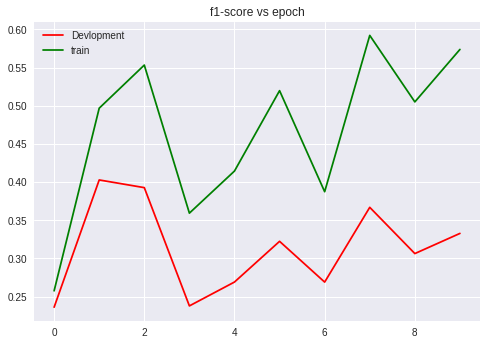

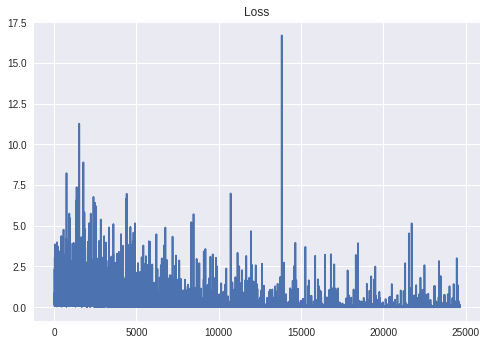

In [0]:
epoch_list = list(range(0, len(train_list)))

import matplotlib.pyplot as plt

plt.plot(epoch_list, test_list, 'r', label='Devlopment')
plt.plot(epoch_list, train_list, 'g', label='train')
plt.title('f1-score vs epoch')
plt.legend()

plt.figure()
plt.plot(loss_list)
plt.title('Loss')

Text(0.5,1,'Loss')

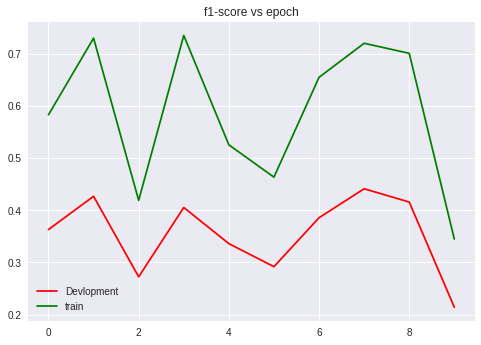

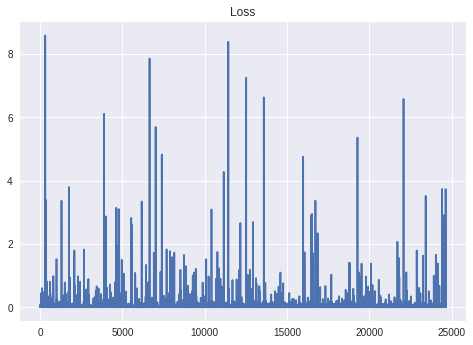

In [0]:
epoch_list = list(range(0, len(train_list)))

import matplotlib.pyplot as plt

plt.plot(epoch_list, test_list, 'r', label='Devlopment')
plt.plot(epoch_list, train_list, 'g', label='train')
plt.title('f1-score vs epoch')
plt.legend()

plt.figure()
plt.plot(loss_list)
plt.title('Loss')

Text(0.5,1,'Loss')

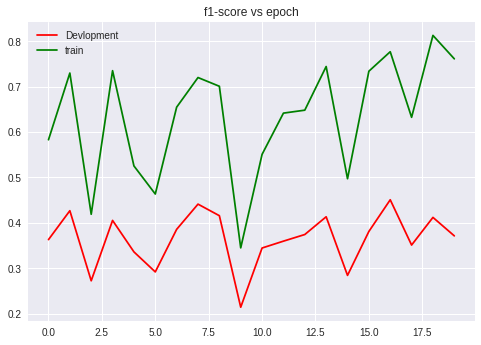

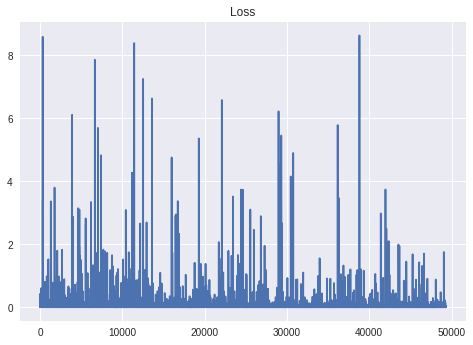

In [0]:
epoch_list = list(range(0, len(train_list)))

import matplotlib.pyplot as plt

plt.plot(epoch_list, test_list, 'r', label='Devlopment')
plt.plot(epoch_list, train_list, 'g', label='train')
plt.title('f1-score vs epoch')
plt.legend()

plt.figure()
plt.plot(loss_list)
plt.title('Loss')

Text(0.5,1,'Loss')

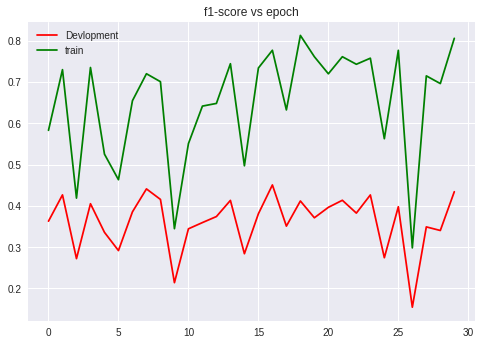

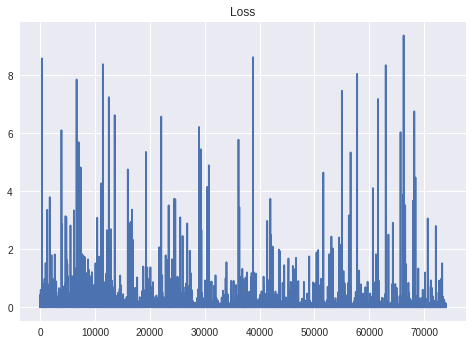

In [0]:
epoch_list = list(range(0, len(train_list)))

import matplotlib.pyplot as plt

plt.plot(epoch_list, test_list, 'r', label='Devlopment')
plt.plot(epoch_list, train_list, 'g', label='train')
plt.title('f1-score vs epoch')
plt.legend()

plt.figure()
plt.plot(loss_list)
plt.title('Loss')

Text(0.5,1,'Loss')

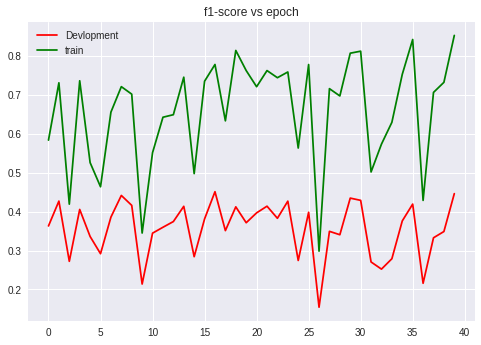

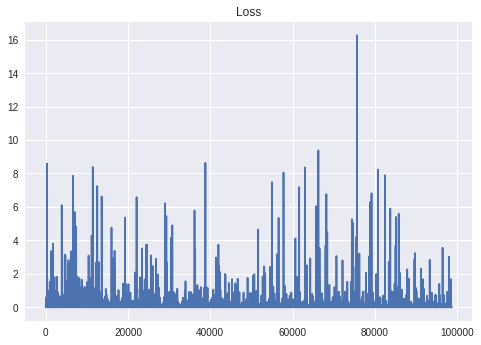

In [0]:
epoch_list = list(range(0, len(train_list)))

import matplotlib.pyplot as plt

plt.plot(epoch_list, test_list, 'r', label='Devlopment')
plt.plot(epoch_list, train_list, 'g', label='train')
plt.title('f1-score vs epoch')
plt.legend()

plt.figure()
plt.plot(loss_list)
plt.title('Loss')

Text(0.5,1,'Loss')

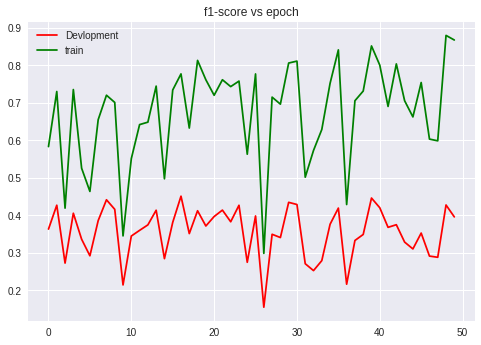

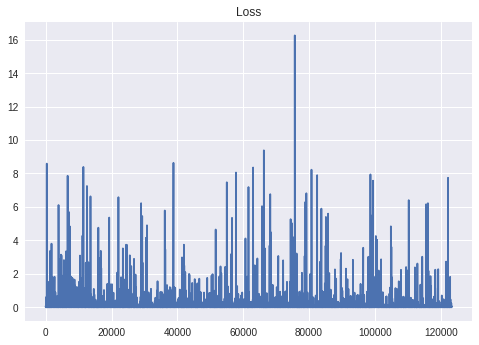

In [0]:
epoch_list = list(range(0, len(train_list)))

import matplotlib.pyplot as plt

plt.plot(epoch_list, test_list, 'r', label='Devlopment')
plt.plot(epoch_list, train_list, 'g', label='train')
plt.title('f1-score vs epoch')
plt.legend()

plt.figure()
plt.plot(loss_list)
plt.title('Loss')

In [0]:
results = pd.DataFrame({"train": train_list, "val":test_list})
results.to_csv("results_v1.csv")

In [0]:
'''
Final Test scores
'''
test_dataset = Transform(sim_test, pd.DataFrame(desc_test).to_dict('records'), y_test,
                       word2idx)  # feature2idx,
test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)
test_loader = torch.utils.data.DataLoader(
   test_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=5,
   pin_memory=True)

test_acc, test_f1, test_recall = validate(test_loader, matcher)


In [52]:
test_acc, test_f1, test_recall

(0.9981332784297577, 0.4035087719298246, 0.4423076923076923)

In [0]:
'''
Loading and saving model
'''
model_name_cur = "matcher_"+"_epoch_"+str(epoch+1)+"_F1_"+str(round(test_f1*100,2)).replace('.','_')+".mdl"
torch.save(matcher.state_dict(), model_name_cur+'.pt')
matcher.load_state_dict(torch.load(model_name_cur+'.pt'))






